In [1]:
import tarfile
from pathlib import Path

tar_path = "cv-corpus-22.0-2025-06-20-hi.tar.gz"
extract_dir = Path("cv_hindi")

if not extract_dir.exists():
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print("✅ Extracted to", extract_dir)
else:
    print("Already extracted:", extract_dir)

# check what’s inside
for p in (extract_dir).rglob("*") :
    print(p)
    break  


Already extracted: cv_hindi
cv_hindi\cv-corpus-22.0-2025-06-20


In [2]:
import pandas as pd
from pathlib import Path

data_dir = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")

df = pd.read_csv(data_dir / "validated.tsv", sep="\t")

print("Rows:", len(df))
print("Columns:", df.columns.tolist())

df.head()[["path", "sentence", "client_id"]]


Rows: 10991
Columns: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment']


,path,sentence,client_id
0,common_voice_hi_32761781.mp3,अब रामपुर में अखिलेश बांटेंगे लैपटॉप का 'लॉलीपॉप',0a0db76f30e3d011216425efa204fa0d3064767656b913...
1,common_voice_hi_28951344.mp3,Flipkart: बंपर ऑफर्स के साथ बिक रहा है Lenovo ...,0a83baf2d66baec284d04967be435be6e6678285ac85d5...
2,common_voice_hi_38247205.mp3,मैं मुसीबत में पड़ गया।,0b0be66321658747b6942ac54496bcf15f205ec5468184...
3,common_voice_hi_27972227.mp3,"सुशील मोदी है 'अफवाह मियां', बिगड़ चुका है मान...",0da032e5bf4a63a5c9c3635155d8b45eb4ede0261ddae3...
4,common_voice_hi_37868078.mp3,प. बंगाल में मुस्लिम आरक्षण को भाजपा देगी चुनौती,17306c4d97ad8d7c04ac7c04602b8fedcfa3c2ebcd61c2...


In [3]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_JAX"] = "1"
print("Set TRANSFORMERS_NO_TF =", os.getenv("TRANSFORMERS_NO_TF"))
print("Set TRANSFORMERS_NO_JAX =", os.getenv("TRANSFORMERS_NO_JAX"))


Set TRANSFORMERS_NO_TF = 1
Set TRANSFORMERS_NO_JAX = 1


In [5]:
from transformers import pipeline
import pandas as pd
from pathlib import Path
from jiwer import wer
import torchaudio
import torch

data_dir = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
clips_dir = data_dir / "clips"
df = pd.read_csv(data_dir / "validated.tsv", sep="\t")

row = df.iloc[0]
audio_path = clips_dir / row["path"]
reference = str(row["sentence"])

waveform, sr = torchaudio.load(str(audio_path))  
if waveform.shape[0] > 1:                         
    waveform = torch.mean(waveform, dim=0, keepdim=True)

target_sr = 16000
if sr != target_sr:
    resampler = torchaudio.transforms.Resample(sr, target_sr)
    waveform = resampler(waveform)
    sr = target_sr

audio_input = {"array": waveform.squeeze().numpy(), "sampling_rate": sr}

asr = pipeline(
    "automatic-speech-recognition",
    model="collabora/whisper-small-hindi",  
    device=-1
)

pred = asr(audio_input, generate_kwargs={"language":"hi", "task":"transcribe"})
hypothesis = pred["text"]

print("AUDIO:", audio_path.name)
print("REF:", reference)
print("HYP:", hypothesis)
print("WER:", wer(reference, hypothesis))


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
Device set to use cpu
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


AUDIO: common_voice_hi_32761781.mp3
REF: अब रामपुर में अखिलेश बांटेंगे लैपटॉप का 'लॉलीपॉप'
HYP:  अब रामपुर में अखिलेश बाटेंगे लैपटॉप का लॉलीपॉप
WER: 0.25


In [6]:
import re, torch, torchaudio

def load_audio_noffmpeg(path, target_sr=16000):
    wav, sr = torchaudio.load(str(path))           
    if wav.shape[0] > 1:                           
        wav = torch.mean(wav, dim=0, keepdim=True)
    if sr != target_sr:                            
        wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
    return {"array": wav.squeeze().numpy(), "sampling_rate": target_sr}

def normalize_hi(s: str) -> str:
    s = str(s)
    s = s.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    s = s.replace("।", " ")          
    s = s.lower()                    
    # keep Hindi letters, digits, and spaces; drop most other punctuation
    s = re.sub(r"[^ \u0900-\u097F0-9a-z]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [7]:
from transformers import pipeline
import pandas as pd
from pathlib import Path
from jiwer import wer, cer

data_dir = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
clips_dir = data_dir / "clips"
df = pd.read_csv(data_dir / "validated.tsv", sep="\t")

asr = pipeline("automatic-speech-recognition",
               model="collabora/whisper-small-hindi",
               device=-1)

subset = df.sample(n=25, random_state=42).reset_index(drop=True)

refs_norm, hyps_norm = [], []
for i, r in subset.iterrows():
    audio = load_audio_noffmpeg(clips_dir / r["path"])
    out = asr(audio, generate_kwargs={"language":"hi", "task":"transcribe"})
    ref = normalize_hi(r["sentence"])
    hyp = normalize_hi(out["text"])
    refs_norm.append(ref); hyps_norm.append(hyp)
    if i < 3:
        print(f"[{i}] REF: {ref}\n    HYP: {hyp}\n")

print(f"\nAverage WER (normalized, {len(subset)} clips): {wer(refs_norm, hyps_norm):.3f}")
print(f"Average CER (normalized): {cer(refs_norm, hyps_norm):.3f}")


Device set to use cpu
c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[0] REF: मेरा भाग जाने का मन हुआ
    HYP: मेरा बॉग जॉनी कब मन हुआ

[1] REF: इनसाइड स्टोरी भारतीय सेना ने म्यांमार में ऐसे किया वार
    HYP: इनसाइट स्टोरीः भारतीय सेना ने म्यांमार में ऐसे किया वार

[2] REF: गुजरात में डोमिनोज ने बंद किया नॉन वेज pizza बेचना मेन्यू से हुए गायब
    HYP: गुजरात में डोमिनोज ने बंद किया नॉनवेज पिज़्ज़ा बेचना मेन्यू से हुए गायब


Average WER (normalized, 25 clips): 0.123
Average CER (normalized): 0.039


In [8]:
from pathlib import Path
import pandas as pd
from jiwer import wer, cer

out_dir = Path("reports"); out_dir.mkdir(parents=True, exist_ok=True)

rows = []
for _, r in subset.iterrows():  
    audio = load_audio_noffmpeg(clips_dir / r["path"])
    out = asr(audio, generate_kwargs={"language":"hi","task":"transcribe"})
    ref, hyp = str(r["sentence"]), out["text"]
    ref_n, hyp_n = normalize_hi(ref), normalize_hi(hyp)
    rows.append({
        "audio": r["path"],
        "ref": ref,
        "hyp": hyp,
        "ref_norm": ref_n,
        "hyp_norm": hyp_n,
        "wer": wer(ref_n, hyp_n),
        "cer": cer(ref_n, hyp_n)
    })

res = pd.DataFrame(rows)
csv_path = out_dir / "predictions_cv22_sample25.csv"
res.to_csv(csv_path, index=False, encoding="utf-8")
print("Saved:", csv_path)
print("Average WER:", res["wer"].mean(), "Average CER:", res["cer"].mean())

res.sort_values("wer", ascending=False).head(5)[["audio","ref","hyp","wer"]]


Saved: reports\predictions_cv22_sample25.csv
Average WER: 0.1228988788988789 Average CER: 0.041486779901887906


,audio,ref,hyp,wer
0,common_voice_hi_25004046.mp3,मेरा भाग जाने का मन हुआ।,मेरा बॉग जॉनी कब मन हुआ।,0.500000
24,common_voice_hi_23830780.mp3,वह कहानी सुन कर पागल हो गया।,<Noise/> वह कहानी सुनकर पागल हो गया।,0.428571
21,common_voice_hi_26116077.mp3,तुम ने टॉम को कहाँ भेजा?,तुमने टॉम को कहाँ भेजा?,0.333333
15,common_voice_hi_26033098.mp3,"तड़पता रहा करंट से झुलसा बच्चा, मंत्री जी की श...","लगता रहा करंट से झुलसा बच्चा, मंत्रीजी की शान...",0.285714
8,common_voice_hi_25149634.mp3,"कश्यप और देवेंद्रो चमके, अन्य भारतीयों ने किया...",कश्यप और देवेंद्र चमकेः अन्य भारतीयों ने किया...,0.222222


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


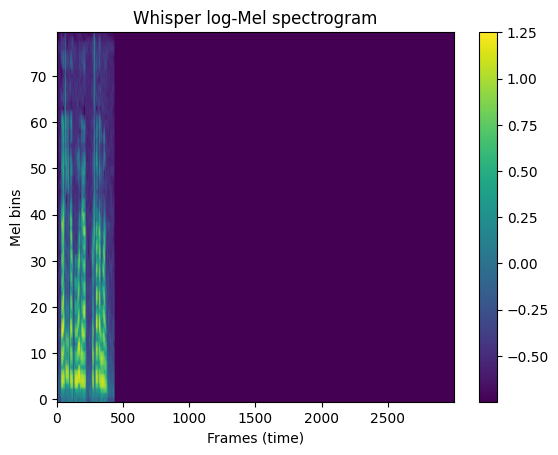

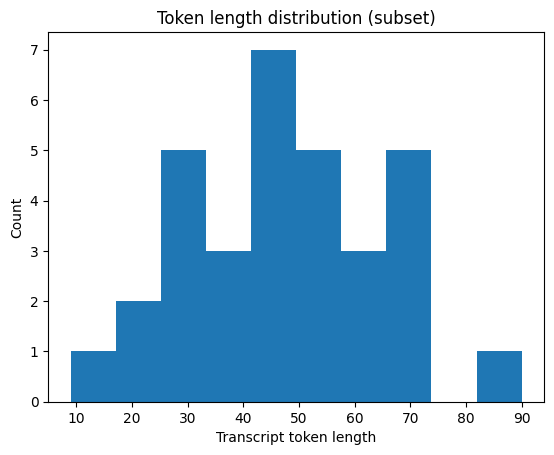

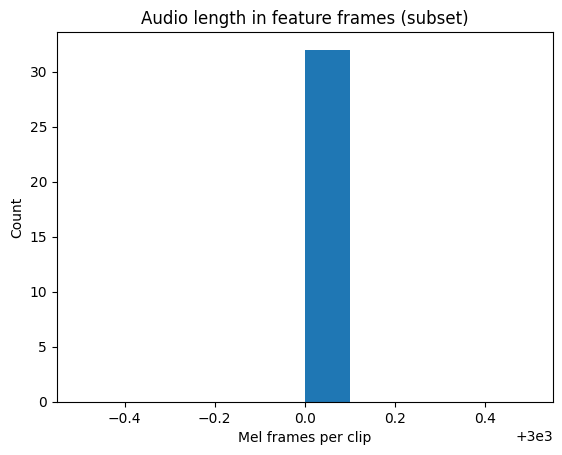

Example transcript: कराची की तरफ मोड़ा गया कृष्णा का विमान
Tokens: 44 | Mel frames: 3000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoProcessor

try:
    subset
    clips_dir
    load_audio_noffmpeg
    normalize_hi
except NameError:
    import pandas as pd, re, torch, torchaudio
    def load_audio_noffmpeg(path, target_sr=16000):
        wav, sr = torchaudio.load(str(path))
        if wav.shape[0] > 1:
            wav = torch.mean(wav, dim=0, keepdim=True)
        if sr != target_sr:
            wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
        return {"array": wav.squeeze().numpy(), "sampling_rate": target_sr}
    def normalize_hi(s: str) -> str:
        s = str(s)
        s = s.replace("’","'").replace("‘","'").replace("“",'"').replace("”",'"')
        s = s.replace("।"," ").lower()
        import re
        s = re.sub(r"[^ \u0900-\u097F0-9a-z]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s
    data_dir = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
    df = pd.read_csv(data_dir / "validated.tsv", sep="\t")
    subset = df.sample(n=12, random_state=123).reset_index(drop=True)
    clips_dir = data_dir / "clips"

processor = AutoProcessor.from_pretrained("collabora/whisper-small-hindi")

# --- pick one example ---
row0 = subset.iloc[0]
audio0 = load_audio_noffmpeg(clips_dir / row0["path"])
feats0 = processor.feature_extractor(
    audio0["array"], sampling_rate=audio0["sampling_rate"], return_tensors="pt"
).input_features[0].numpy()            # [80, T]
tokens0 = processor.tokenizer(
    normalize_hi(row0["sentence"]), return_tensors="pt", add_special_tokens=True
).input_ids[0].numpy()

# 1) Log-Mel spectrogram (what Whisper sees)
plt.figure()
plt.imshow(feats0, origin="lower", aspect="auto")
plt.xlabel("Frames (time)")
plt.ylabel("Mel bins")
plt.title("Whisper log-Mel spectrogram")
plt.colorbar()
plt.show()

# 2) Token length distribution on a small subset
lens, mel_frames = [], []
for _, r in subset.iterrows():
    a = load_audio_noffmpeg(clips_dir / r["path"])
    f = processor.feature_extractor(a["array"], sampling_rate=a["sampling_rate"], return_tensors="pt").input_features[0].numpy()
    mel_frames.append(f.shape[-1])
    t = processor.tokenizer(normalize_hi(r["sentence"]), return_tensors="pt", add_special_tokens=True).input_ids[0].numpy()
    lens.append(len(t))

plt.figure()
plt.hist(lens, bins=10)
plt.xlabel("Transcript token length")
plt.ylabel("Count")
plt.title("Token length distribution (subset)")
plt.show()

plt.figure()
plt.hist(mel_frames, bins=10)
plt.xlabel("Mel frames per clip")
plt.ylabel("Count")
plt.title("Audio length in feature frames (subset)")
plt.show()

print("Example transcript:", row0["sentence"])
print("Tokens:", len(tokens0), "| Mel frames:", feats0.shape[-1])


In [13]:

from pathlib import Path
import pandas as pd
from transformers import pipeline
from jiwer import wer, cer

try:
    load_audio_noffmpeg
    normalize_hi
except NameError:
    import torch, torchaudio, re
    def load_audio_noffmpeg(path, target_sr=16000):
        wav, sr = torchaudio.load(str(path))
        if wav.shape[0] > 1:
            wav = torch.mean(wav, dim=0, keepdim=True)
        if sr != target_sr:
            wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
        return {"array": wav.squeeze().numpy(), "sampling_rate": target_sr}
    def normalize_hi(s: str) -> str:
        s = str(s)
        s = s.replace("’","'").replace("‘","'").replace("“",'"').replace("”",'"')
        s = s.replace("।"," ").lower()
        s = re.sub(r"[^ \u0900-\u097F0-9a-z]", " ", s)
        s = re.sub(r"\s+"," ", s).strip()
        return s

# --- paths & data ---
data_dir  = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
clips_dir = data_dir / "clips"
test_tsv  = Path("reports/cv22_test.tsv")

if test_tsv.exists():
    test_df = pd.read_csv(test_tsv, sep="\t")
    print(f"Loaded TEST split from {test_tsv} (rows={len(test_df)})")
else:
    print("WARNING: test split not found. Falling back to random sample from validated.tsv (not speaker-disjoint).")
    test_df = pd.read_csv(data_dir / "validated.tsv", sep="\t")

asr = pipeline("automatic-speech-recognition",
               model="collabora/whisper-small-hindi",
               device=-1)

sample = test_df.sample(n=min(100, len(test_df)), random_state=0).reset_index(drop=True)

rows = []
refs, hyps = [], []
for i, r in sample.iterrows():
    audio = load_audio_noffmpeg(clips_dir / r["path"])
    out = asr(audio, generate_kwargs={"language":"hi","task":"transcribe"})
    ref = normalize_hi(r["sentence"])
    hyp = normalize_hi(out["text"])
    refs.append(ref); hyps.append(hyp)
    rows.append({"audio": r["path"], "ref": ref, "hyp": hyp})
    if i < 3:
        print(f"[{i}] REF: {ref}\n    HYP: {hyp}\n")

avg_wer = wer(refs, hyps)
avg_cer = cer(refs, hyps)
print(f"\nTEST WER (normalized, {len(sample)} clips): {avg_wer:.3f}")
print(f"TEST CER (normalized): {avg_cer:.3f}")

out_dir = Path("reports"); out_dir.mkdir(parents=True, exist_ok=True)
pd.DataFrame(rows).to_csv(out_dir / "cv22_test_sample100_preds.csv", index=False, encoding="utf-8")
print("Saved predictions to:", out_dir / "cv22_test_sample100_preds.csv")


Device set to use cpu
c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[0] REF: दिल्ली स्कूल प्रशासन की लापरवाही से छात्रा की मौत
    HYP: देवी स्कूल प्रशासन की लापरवाही से छात्रा की मौत

[1] REF: गाजियाबाद घरों की नई बहार
    HYP: गाजियाबादः घरों की नई बहार

[2] REF: बॉलीवुड में धर्मेंद्र ने ऐसे शुरू किया था शर्टलेस ट्रेंड खुद बताया
    HYP: गोविंद में दरभंद्र ने ऐसे शुरू किया था शॉर्टमेस ट्रेंड खुद बताएंगे


TEST WER (normalized, 100 clips): 0.175
TEST CER (normalized): 0.105
Saved predictions to: reports\cv22_test_sample100_preds.csv


In [15]:

from pathlib import Path
import pandas as pd
import torch, torchaudio, re
from torch.utils.data import Dataset
from transformers import AutoProcessor, WhisperForConditionalGeneration

def load_audio_noffmpeg(path, target_sr=16000):
    wav, sr = torchaudio.load(str(path))
    if wav.shape[0] > 1:  
        wav = torch.mean(wav, dim=0, keepdim=True)
    if sr != target_sr:   
        wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
    return {"array": wav.squeeze().numpy(), "sampling_rate": target_sr}

def normalize_hi(s: str) -> str:
    s = str(s)
    s = s.replace("’","'").replace("‘","'").replace("“",'"').replace("”",'"')
    s = s.replace("।"," ").lower()
    s = re.sub(r"[^ \u0900-\u097F0-9a-z]", " ", s)
    s = re.sub(r"\s+"," ", s).strip()
    return s

# ---- paths & splits ----
data_dir  = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
clips_dir = data_dir / "clips"
train_tsv = Path("reports/cv22_train.tsv")
dev_tsv   = Path("reports/cv22_dev.tsv")

if not train_tsv.exists() or not dev_tsv.exists():
    print("WARNING: speaker-disjoint splits not found; creating quick random split.")
    df_all = pd.read_csv(data_dir / "validated.tsv", sep="\t")
    msk = df_all.sample(frac=0.8, random_state=42).index
    train_df = df_all.loc[msk].reset_index(drop=True)
    dev_df   = df_all.drop(msk).reset_index(drop=True)
else:
    train_df = pd.read_csv(train_tsv, sep="\t")
    dev_df   = pd.read_csv(dev_tsv,   sep="\t")

train_df_small = train_df.sample(n=min(400, len(train_df)), random_state=1).reset_index(drop=True)
dev_df_small   = dev_df.sample(n=min(120, len(dev_df)),   random_state=1).reset_index(drop=True)

processor = AutoProcessor.from_pretrained("collabora/whisper-small-hindi")
model = WhisperForConditionalGeneration.from_pretrained("collabora/whisper-small-hindi")
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="hi", task="transcribe")
model.config.suppress_tokens = []
model.config.use_cache = False

class CVDataset(Dataset):
    def __init__(self, df, clips_dir, processor):
        self.df = df.reset_index(drop=True)
        self.clips_dir = clips_dir
        self.processor = processor
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        audio = load_audio_noffmpeg(self.clips_dir / r["path"])
        feats = self.processor.feature_extractor(
            audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt"
        ).input_features[0]                          # [80, T] torch.Tensor
        text = normalize_hi(r["sentence"])
        labels = self.processor.tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids[0]
        return {"input_features": feats, "labels": labels}

train_ds = CVDataset(train_df_small, clips_dir, processor)
dev_ds   = CVDataset(dev_df_small,   clips_dir, processor)

class SpeechSeq2SeqCollator:
    def __init__(self, pad_token_id, label_pad_token_id=-100):
        self.pad_token_id = pad_token_id
        self.label_pad_token_id = label_pad_token_id
    def __call__(self, features):
        feats = [f["input_features"] for f in features]   
        max_T = max(x.shape[-1] for x in feats)
        feats_padded = torch.stack([
            torch.nn.functional.pad(x, (0, max_T - x.shape[-1])) for x in feats
        ])  

        labels = [f["labels"] for f in features]
        max_L = max(l.size(0) for l in labels)
        labels_padded = torch.full((len(labels), max_L), self.label_pad_token_id, dtype=torch.long)
        for i, l in enumerate(labels):
            labels_padded[i, :l.size(0)] = l

        return {"input_features": feats_padded, "labels": labels_padded}

collator = SpeechSeq2SeqCollator(pad_token_id=processor.tokenizer.pad_token_id)

ex = train_ds[0]
print("One example — mel shape:", tuple(ex["input_features"].shape), "| label tokens:", int(ex["labels"].shape[0]))
print(f"Train/dev sizes: {len(train_ds)} / {len(dev_ds)}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device for training:", device)
model.to(device)


One example — mel shape: (80, 3000) | label tokens: 63
Train/dev sizes: 400 / 120
Device for training: cpu


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [17]:

import math, time
import torch
from torch.utils.data import DataLoader
from jiwer import wer, cer
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collator)
dev_loader   = DataLoader(dev_ds,   batch_size=2, shuffle=False, collate_fn=collator)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
grad_clip = 1.0

train_steps, train_losses = [], []
eval_steps, dev_wers, dev_cers = [], [], []

max_train_steps = 60          
eval_every      = 20         

model.train()
step = 0
t0 = time.time()

def evaluate_dev(max_batches=20):
    """Compute WER/CER on a small dev slice for speed."""
    model.eval()
    refs, hyps = [], []
    with torch.no_grad():
        for b_idx, batch in enumerate(dev_loader):
            if b_idx >= max_batches:
                break
            feats = batch["input_features"].to(device)
            gen_ids = model.generate(
                inputs=feats,
                max_length=225,
                num_beams=1
            )
            pred_texts = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
            labels = batch["labels"].clone()
            labels[labels == -100] = processor.tokenizer.pad_token_id
            ref_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

            pred_texts = [normalize_hi(s) for s in pred_texts]
            ref_texts  = [normalize_hi(s) for s in ref_texts]

            refs.extend(ref_texts)
            hyps.extend(pred_texts)

    w = wer(refs, hyps)
    c = cer(refs, hyps)
    model.train()
    return float(w), float(c)

for epoch in range(1):  
    for batch in train_loader:
        step += 1
        feats = batch["input_features"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad(set_to_none=True)
        out = model(input_features=feats, labels=labels)
        loss = out.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        train_steps.append(step)
        train_losses.append(float(loss.detach().cpu()))
        if step % 10 == 0:
            print(f"step {step:4d} | loss {train_losses[-1]:.4f}")

        if step % eval_every == 0:
            w, c = evaluate_dev(max_batches=10)  
            eval_steps.append(step)
            dev_wers.append(w); dev_cers.append(c)
            print(f"  ↳ dev WER={w:.3f} CER={c:.3f}")

        if step >= max_train_steps:
            break
    if step >= max_train_steps:
        break

t1 = time.time()
print(f"Finished {step} steps in {t1 - t0:.1f}s")


step   10 | loss 0.3016


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:655: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


step   20 | loss 0.0925
  ↳ dev WER=0.202 CER=0.073
step   30 | loss 0.3088
step   40 | loss 0.0816
  ↳ dev WER=0.191 CER=0.079
step   50 | loss 0.0442
step   60 | loss 0.0225
  ↳ dev WER=0.186 CER=0.060
Finished 60 steps in 1221.9s


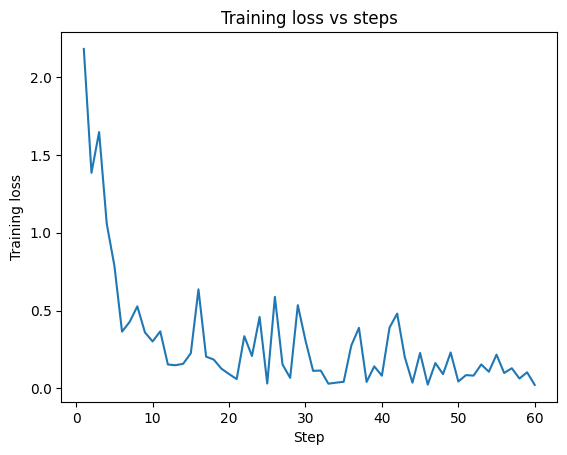

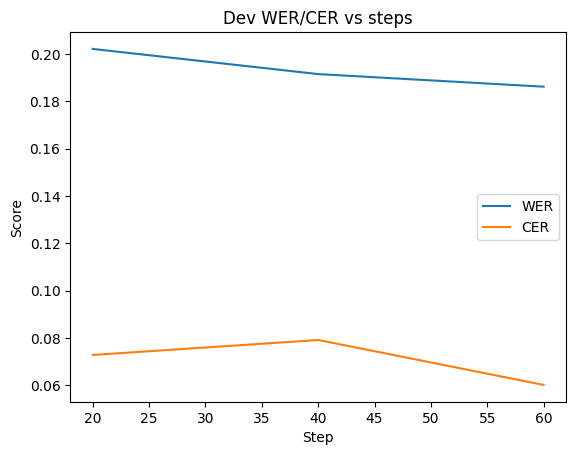

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_steps, train_losses)
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss vs steps")
plt.show()

if len(eval_steps) > 0:
    plt.figure()
    plt.plot(eval_steps, dev_wers, label="WER")
    plt.plot(eval_steps, dev_cers, label="CER")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("Dev WER/CER vs steps")
    plt.legend()
    plt.show()
else:
    print("No eval points logged yet.")


In [19]:
from pathlib import Path
import pandas as pd
from jiwer import wer, cer

test_tsv = Path("reports/cv22_test.tsv")
data_dir  = Path("cv_hindi/cv-corpus-22.0-2025-06-20/hi")
clips_dir = data_dir / "clips"

if not test_tsv.exists():
    print("WARNING: reports/cv22_test.tsv not found; using a random validated sample instead.")
    test_df = pd.read_csv(data_dir / "validated.tsv", sep="\t").sample(n=100, random_state=7)
else:
    test_df = pd.read_csv(test_tsv, sep="\t").sample(n=100, random_state=7)

refs, hyps = [], []
model.eval()
with torch.no_grad():
    for _, r in test_df.iterrows():
        audio = load_audio_noffmpeg(clips_dir / r["path"])
        feats = processor.feature_extractor(
            audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt"
        ).input_features.to(device)

        gen_ids = model.generate(inputs=feats, max_length=225)
        hyp = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0]
        ref = r["sentence"]

        refs.append(normalize_hi(ref))
        hyps.append(normalize_hi(hyp))

w = wer(refs, hyps)
c = cer(refs, hyps)
print(f"TEST WER after fine-tune: {w:.3f}")
print(f"TEST CER after fine-tune: {c:.3f}")


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:655: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


TEST WER after fine-tune: 0.148
TEST CER after fine-tune: 0.047


In [21]:
from pathlib import Path
save_dir = Path("models/whisper_small_hi_ft")
save_dir.mkdir(parents=True, exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print("Saved to:", save_dir)


c:\Users\gfxsc\Desktop\Speech\.venv\Lib\site-packages\transformers\modeling_utils.py:4037: UserWarning: Moving the following attributes in the config to the generation config: {'suppress_tokens': []}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Saved to: models\whisper_small_hi_ft


In [23]:

pip install streamlit


  Using cached pyarrow-21.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.0 MB 4.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/10.0 MB 4.2 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/10.0 MB 4.2 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/10.0 MB 4.2 MB/s eta 0:00:02
   ---------------- ----------------------- 4.2/10.0 MB 4.2 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.0 MB 4.1 MB/s eta 0:00:02
   ------------------------- -------------- 6.3/10.0 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/10.0 MB 4.4 MB/s eta 0:00:01
   --------------------------------- ------ 8.4/10.0 MB 4.4 MB/s eta 0:00:01
   ----------------------------------- ---- 8.9/10.0 MB 4.4 MB/s eta 0:00:01
   -----------------